#A.	Setting-up environment
The first step is to build the environment for executing the program, such as preparing the data and declaring the necessary modules.

# A.1 Data download

Press the play button #1 to the left of the code to download the data and other information used in this hands-on course.

The contents are sound data (.wav) prepared for the hands-on course, and meta data (.csv) for listening to and to visualize the sample data.

In [ ]:
#1 Downlod datasets
%%shell
wget https://workshop-aicoe.s3-ap-northeast-1.amazonaws.com/dev_data.zip
wget https://workshop-aicoe.s3-ap-northeast-1.amazonaws.com/filelist.csv
wget https://workshop-aicoe.s3-ap-northeast-1.amazonaws.com/testlist.csv
# Unzip the files to current folder
unzip dev_data.zip

#A.2 Checking the data directory
Please push the folder icon on the toolbar on the left side of your browser. The data etc. in this learning environment are displayed, and you can see that the downloaded files are stored.

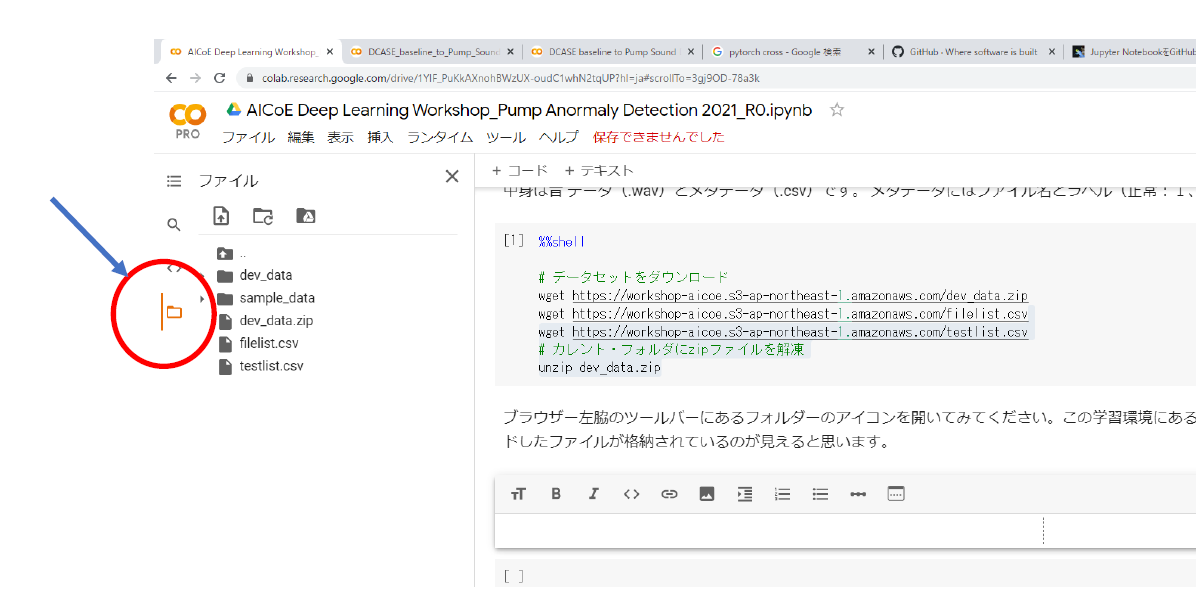

# A.3 Preparation for preprocessing


In [ ]:
#2 Declare the code you need so that you can visualize your progress when training the deep leaning model.
import logging

logging.basicConfig(level=logging.DEBUG, filename="baseline.log")
logger = logging.getLogger(' ')
handler = logging.StreamHandler()
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)

In [ ]:
#3 Calling the required module.
import os
import glob
import time
import torch
from collections import defaultdict
from datetime import timedelta
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

In [ ]:
#4 Declare the file path in the folder for frequent access to data throughout the program.
import pandas as pd

# Declare the file path in the folder so that it is easy to use when reading it in future code.
base_dir = "./dev_data/"
esc_dir = os.path.join(base_dir, "pump/")
audio_dir = os.path.join(esc_dir, "train/")
audio_dir2 = os.path.join(esc_dir, "test/")

# Also load a list to audition samples and draw waveforms and log-melspectrogram.
meta_data = pd.read_csv("filelist.csv")
meta_data2 = pd.read_csv("testlist.csv")

# Output the size of the data for training
data_size = meta_data.shape
print(data_size)

# Output the size of the data for testing
data_size = meta_data2.shape
print(data_size)

(3349, 2)
(856, 2)


#A.4 Load the sample data and listen to the normal and anormal sounds
Let's play the normal and abnormal sounds contained in the test dataset and check what they sound like.

In [ ]:
#5 Code for loading the sample sound data into the Collaboratory
import IPython.display as ipd

def load_wave_data(audio_dir, file_name):
    file_path = os.path.join(audio_dir2, file_name)
    x, fs = librosa.load(file_path)
    return x,fs

In [ ]:
#6 Playback normal data.
normal, fs = load_wave_data(audio_dir2, meta_data2.loc[2, "filename"])
print(meta_data2.loc[2, "filename"])
ipd.Audio(normal, rate=fs)

normal_id_00_00000082.wav


In [ ]:
#7 Playback anormal data.
anormal, fs = load_wave_data(audio_dir2, meta_data2.loc[0, "filename"])
print(meta_data2.loc[0, "filename"])
ipd.Audio(anormal, rate=fs)

anomaly_id_00_00000037.wav



#B.	Preprocessing
In this section, we will prepare a dataset for AI to train.

#B.1 Visualize the sample data

On handlling sound data, captured analog sound data which made of current and voltage is necessary converted to digital data consisting of 0s and 1s. Therefore, sound is collected using a sound collector such as a microphone, and converted from analog to digital using D/A converter. These data are formated into a standard information structure such as the WAV data which is used in this project, and stored in the memory.

The sound data is waveform data with features called frequency and amplitude. In this project, in order to highlight the features of the sound data, we will use a method called Fourier transform to convert the waveform data into components (spectra) for each frequency, and then apply a filter called a filter bank to convert them into features of the sound data called log-melspectrogram.

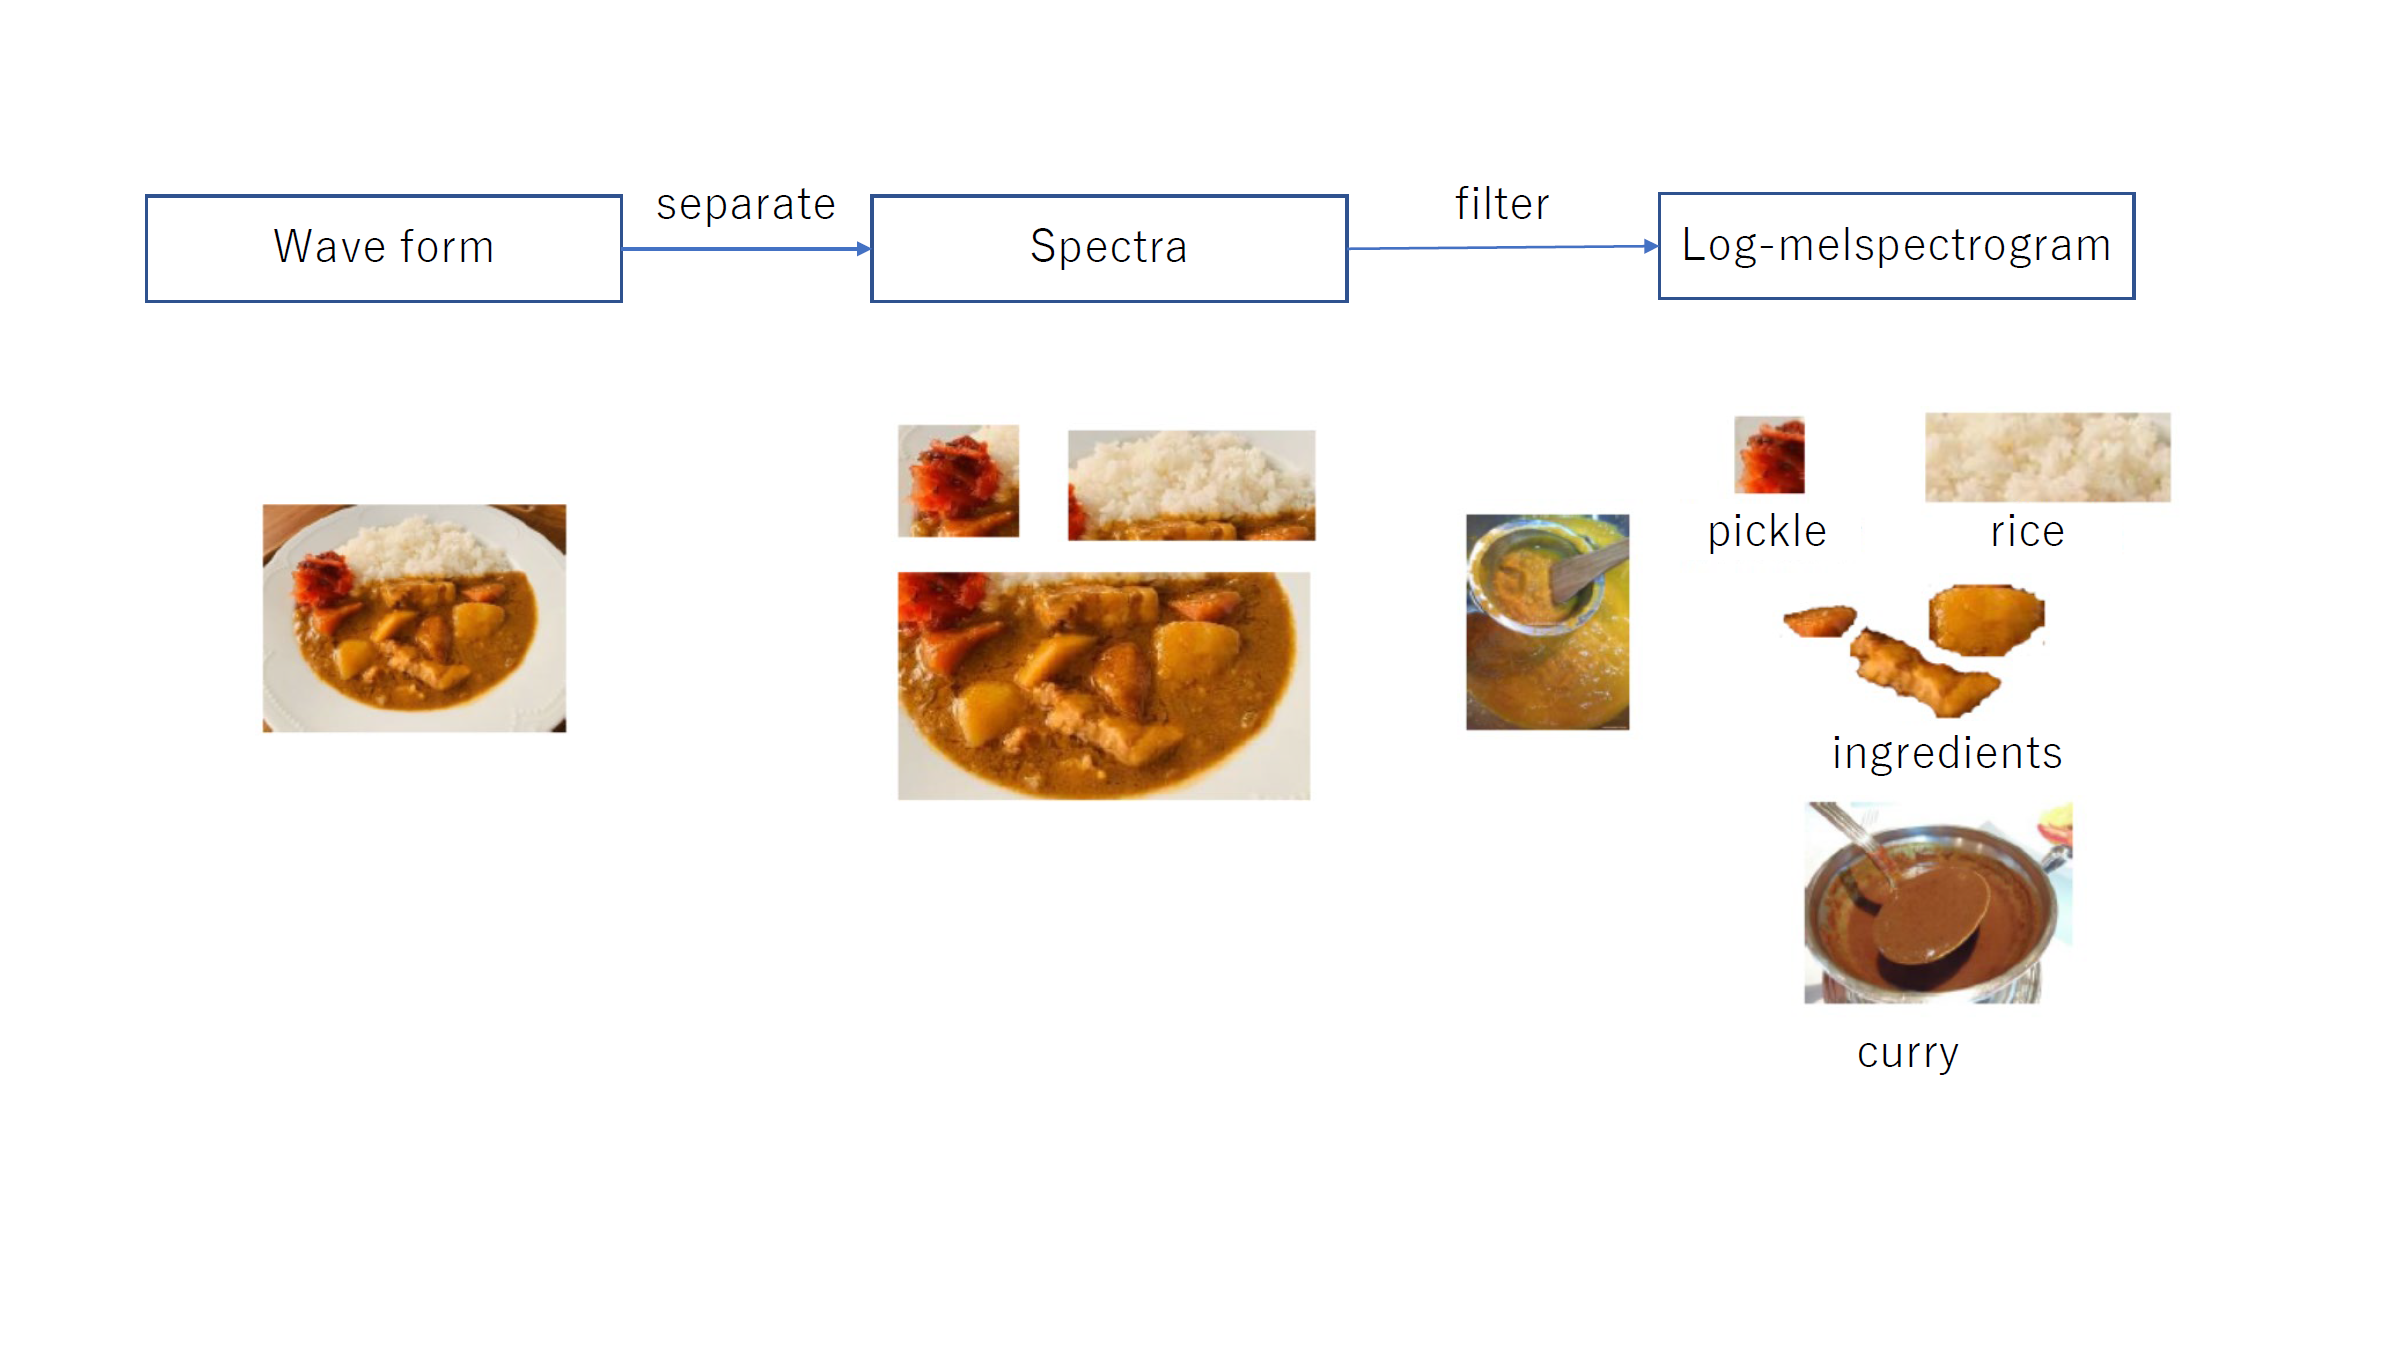

In [ ]:
#8 Convert waveform data to log-melspectrogram
def calculate_melsp(x, n_fft=1024, hop_length=512):
    stft = np.abs(librosa.stft(x, n_fft=n_fft, hop_length=hop_length))**2
    log_stft = librosa.power_to_db(stft)
    melsp = librosa.feature.melspectrogram(S=log_stft,n_mels=64)
    return melsp

In [ ]:
#9 Display the waveform and the log-melspectrogram
# Display the waveform of sound data (.wav)
def show_wave(x):
    plt.plot(x)
    plt.show()

# Disply the log-melspecgtrogram
def show_melsp(melsp, fs):
    librosa.display.specshow(melsp, sr=fs)
    plt.colorbar()
    plt.show()

normal_id_00_00000082.wav
wave size:(220500,)
samping rate:22050


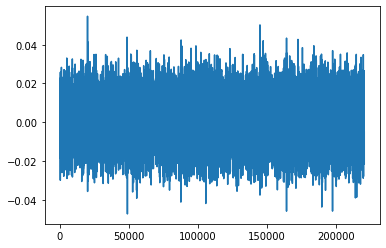

nmelsp size:(64, 431)


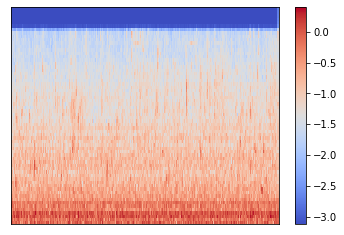

In [ ]:
#10 Call a normal sound data and display this waveform and mel-spectrogram. 
x, fs = load_wave_data(audio_dir2, meta_data2.loc[2, "filename"])
print(meta_data2.loc[2, "filename"])
print("wave size:{0}\nsamping rate:{1}".format(x.shape, fs))
show_wave(x)
melsp = calculate_melsp(x)
print("nmelsp size:{0}".format(melsp.shape))
show_melsp(melsp, fs)

anomaly_id_00_00000037.wav
wave size:(220500,)
samping rate:22050


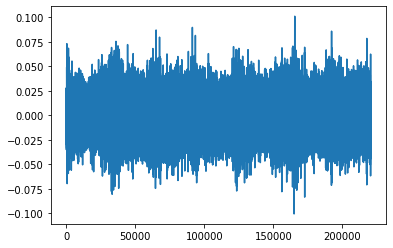

nmelsp size:(64, 431)


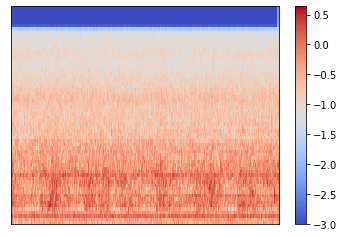

In [ ]:
#11 Call an anormal sound and display this waveform and mel-spectrogram. 
x, fs = load_wave_data(audio_dir2, meta_data2.loc[0, "filename"])
print(meta_data2.loc[0, "filename"])
print("wave size:{0}\nsamping rate:{1}".format(x.shape, fs))
show_wave(x)
melsp = calculate_melsp(x)
print("nmelsp size:{0}".format(melsp.shape))
show_melsp(melsp, fs)

#B.2 Importing data for training and preprocessing the data

In B.1, we learned the pre-processing techniques,using sample data, to convert sound data (.wav) into a log mel spectrogram. In this section, we are going to apply those techniques to all training data and create a training data set.

In [ ]:
#12 Load the sound data (.wav) for training into the Collaboratory.
def file_load(wav_name, mono=False):
    try:
        return librosa.load(wav_name, sr=None, mono=mono)
    except:
        logger.error("file_broken or not exists!! : {}".format(wav_name))

In [ ]:
#13 Convert the read sound data to log mel spectrum data
def file_to_vector_array(file_name,
                         n_mels=64,
                         frames=5,
                         n_fft=1024,
                         hop_length=512,
                         power=2.0):
    """
    convert file_name to a vector array.

    file_name : str
        target .wav file

    return : numpy.array( numpy.array( float ) )
        vector array
        * dataset.shape = (dataset_size, feature_vector_length)
    """
    # 01 calculate the number of dimensions
    dims = n_mels * frames

    # 02_03 generate melspectrogram using librosa
    y, sr = file_load(file_name)
    stft = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))**2
    log_stft = librosa.power_to_db(stft)
    log_mel_spectrogram = librosa.feature.melspectrogram(S=log_stft,n_mels=n_mels)

    # 04 calculate total vector size
    vector_array_size = len(log_mel_spectrogram[0, :]) - frames + 1

    # 05 skip too short clips
    if vector_array_size < 1:
        return np.empty((0, dims))

    # 06 generate feature vectors by concatenating multiframes
    vector_array = np.zeros((vector_array_size, dims))
    for t in range(frames):
        vector_array[:, n_mels * t: n_mels * (t + 1)] = log_mel_spectrogram[:, t: t + vector_array_size].T

    return vector_array

In [ ]:
#14 Numbering each piece of data to make it easier to control
class dcaseDataset(torch.utils.data.Dataset):
    def __init__(self, target_dir, dir_name, ext="wav",
                 n_mels=64, frames=5, n_fft=1024, hop_length=512, power=2.0,
                 transform=None):
        self.transform = transform

        logger.info("target_dir : {}".format(target_dir))

        file_list_path = os.path.abspath(
            "{dir}/{dir_name}/*.{ext}".format(dir=target_dir, dir_name=dir_name,
                                              ext=ext))
        files = sorted(glob.glob(file_list_path))
        if len(files) == 0:
            logger.exception("no_wav_file!!")

        logger.info("train_file num : {num}".format(num=len(files)))

        dims = n_mels * frames
        for idx in range(len(files)):
            vector_array = file_to_vector_array(files[idx],
                                                    n_mels=n_mels,
                                                    frames=frames,
                                                    n_fft=n_fft,
                                                    hop_length=hop_length,
                                                    power=power)
            if idx == 0:
                dataset = np.zeros(
                    (vector_array.shape[0] * len(files), dims), float)

            dataset[vector_array.shape[0] * idx:
                    vector_array.shape[0] * (idx + 1), :] = vector_array

        self.feat_data = dataset

    def __len__(self):
        return self.feat_data.shape[0]  # return num of samples

    def __getitem__(self, index):
        sample = self.feat_data[index, :]  # return vector

        if self.transform:
            sample = self.transform(sample)

        return sample

In [ ]:
#15 Run dataset creation and split the created data into 90% for training and 10% for verification.
dataset = dcaseDataset(target_dir=esc_dir,
                       dir_name="train",
                               n_mels=64,
                               frames=5,
                               n_fft=1024,
                               hop_length=512,
                               power=2.0)
n_samples = len(dataset)
train_size = int(n_samples * (1.0 - 0.1))
subset1_indices = list(range(0, train_size))
subset2_indices = list(range(train_size, n_samples))
train_dataset = torch.utils.data.Subset(dataset, subset1_indices)
val_dataset = torch.utils.data.Subset(dataset, subset2_indices)

2021-06-07 00:23:07,173 - INFO - target_dir : ./dev_data/pump/
2021-06-07 00:23:07,187 - INFO - train_file num : 3349


In [ ]:
#16 Load the data to AI
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=512,
    shuffle=True,
    drop_last=True)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=512,
    shuffle=False,
    drop_last=False)

#C.	Structure of the autoencoder model

In this section, we are going to learn the structure of the autoencoder model that we creat, and look through how it descripted in the code.

#C.1 Description of the model
The conceptual diagram of the autoencoder model is a 9-layer neural network as shown below.

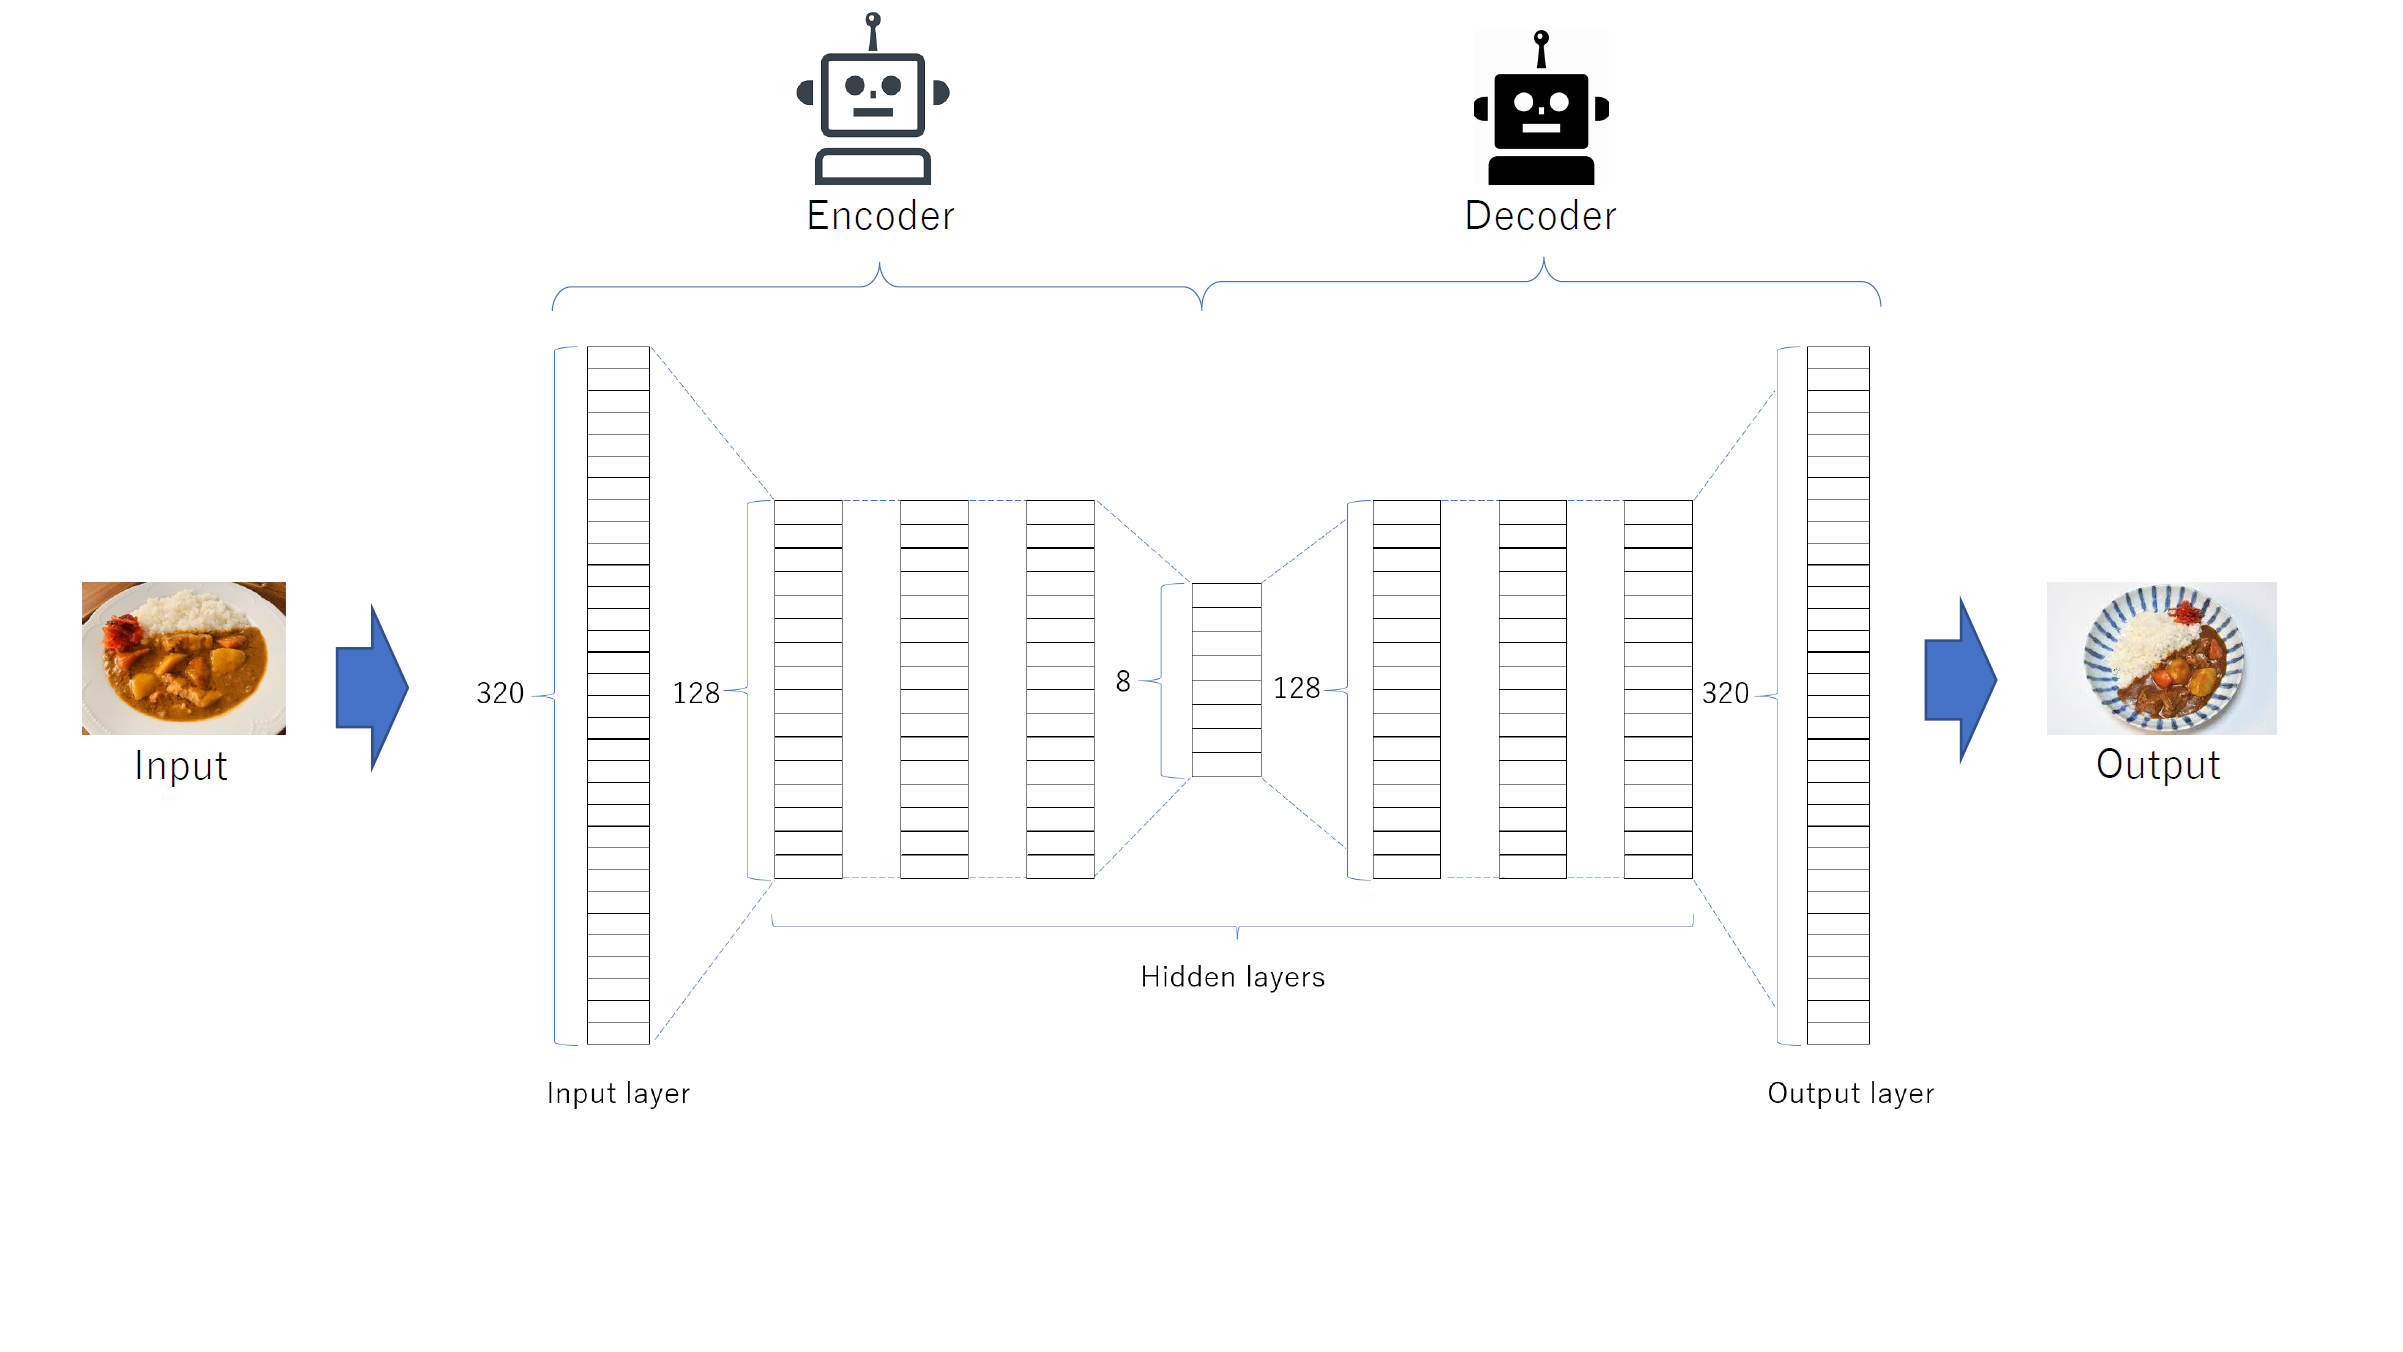

In [ ]:
#17 Description of the autoencorder model
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        layers = [nn.Linear(320, 128),
                  nn.Linear(128, 128),
                  nn.Linear(128, 128),
                  nn.Linear(128, 128),
                  nn.Linear(128, 8),
                  nn.Linear(8, 128),
                  nn.Linear(128, 128),
                  nn.Linear(128, 128),
                  nn.Linear(128, 128),
                  nn.Linear(128, 320), ]
        self.layers = nn.ModuleList(layers)

        bnorms = [nn.BatchNorm1d(128),
                  nn.BatchNorm1d(128),
                  nn.BatchNorm1d(128),
                  nn.BatchNorm1d(128),
                  nn.BatchNorm1d(8),
                  nn.BatchNorm1d(128),
                  nn.BatchNorm1d(128),
                  nn.BatchNorm1d(128),
                  nn.BatchNorm1d(128), ]
        self.bnorms = nn.ModuleList(bnorms)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        hidden = self.relu(self.bnorms[0](self.layers[0](inputs)))  # 320->128
        hidden = self.relu(self.bnorms[1](self.layers[1](hidden)))  # 128->128
        hidden = self.relu(self.bnorms[2](self.layers[2](hidden)))  # 128->128
        hidden = self.relu(self.bnorms[3](self.layers[3](hidden)))  # 128->128
        hidden = self.relu(self.bnorms[4](self.layers[4](hidden)))  # 128->8
        hidden = self.relu(self.bnorms[5](self.layers[5](hidden)))  # 8->128
        hidden = self.relu(self.bnorms[6](self.layers[6](hidden)))  # 128->128
        hidden = self.relu(self.bnorms[7](self.layers[7](hidden)))  # 128->128
        hidden = self.relu(self.bnorms[8](self.layers[8](hidden)))  # 128->128
        output = self.layers[9](hidden)                             # 128->320

        return output

model = AutoEncoder()

# C.2　Forward propagation and back propagation
In deep learning, the process that from AI receives data for training to output results is called forward propagation. Deep learning models also have a feedback mechanism that calculates the error between input and output and updates parameters to reduce the error. This mechanism is called back propagation.

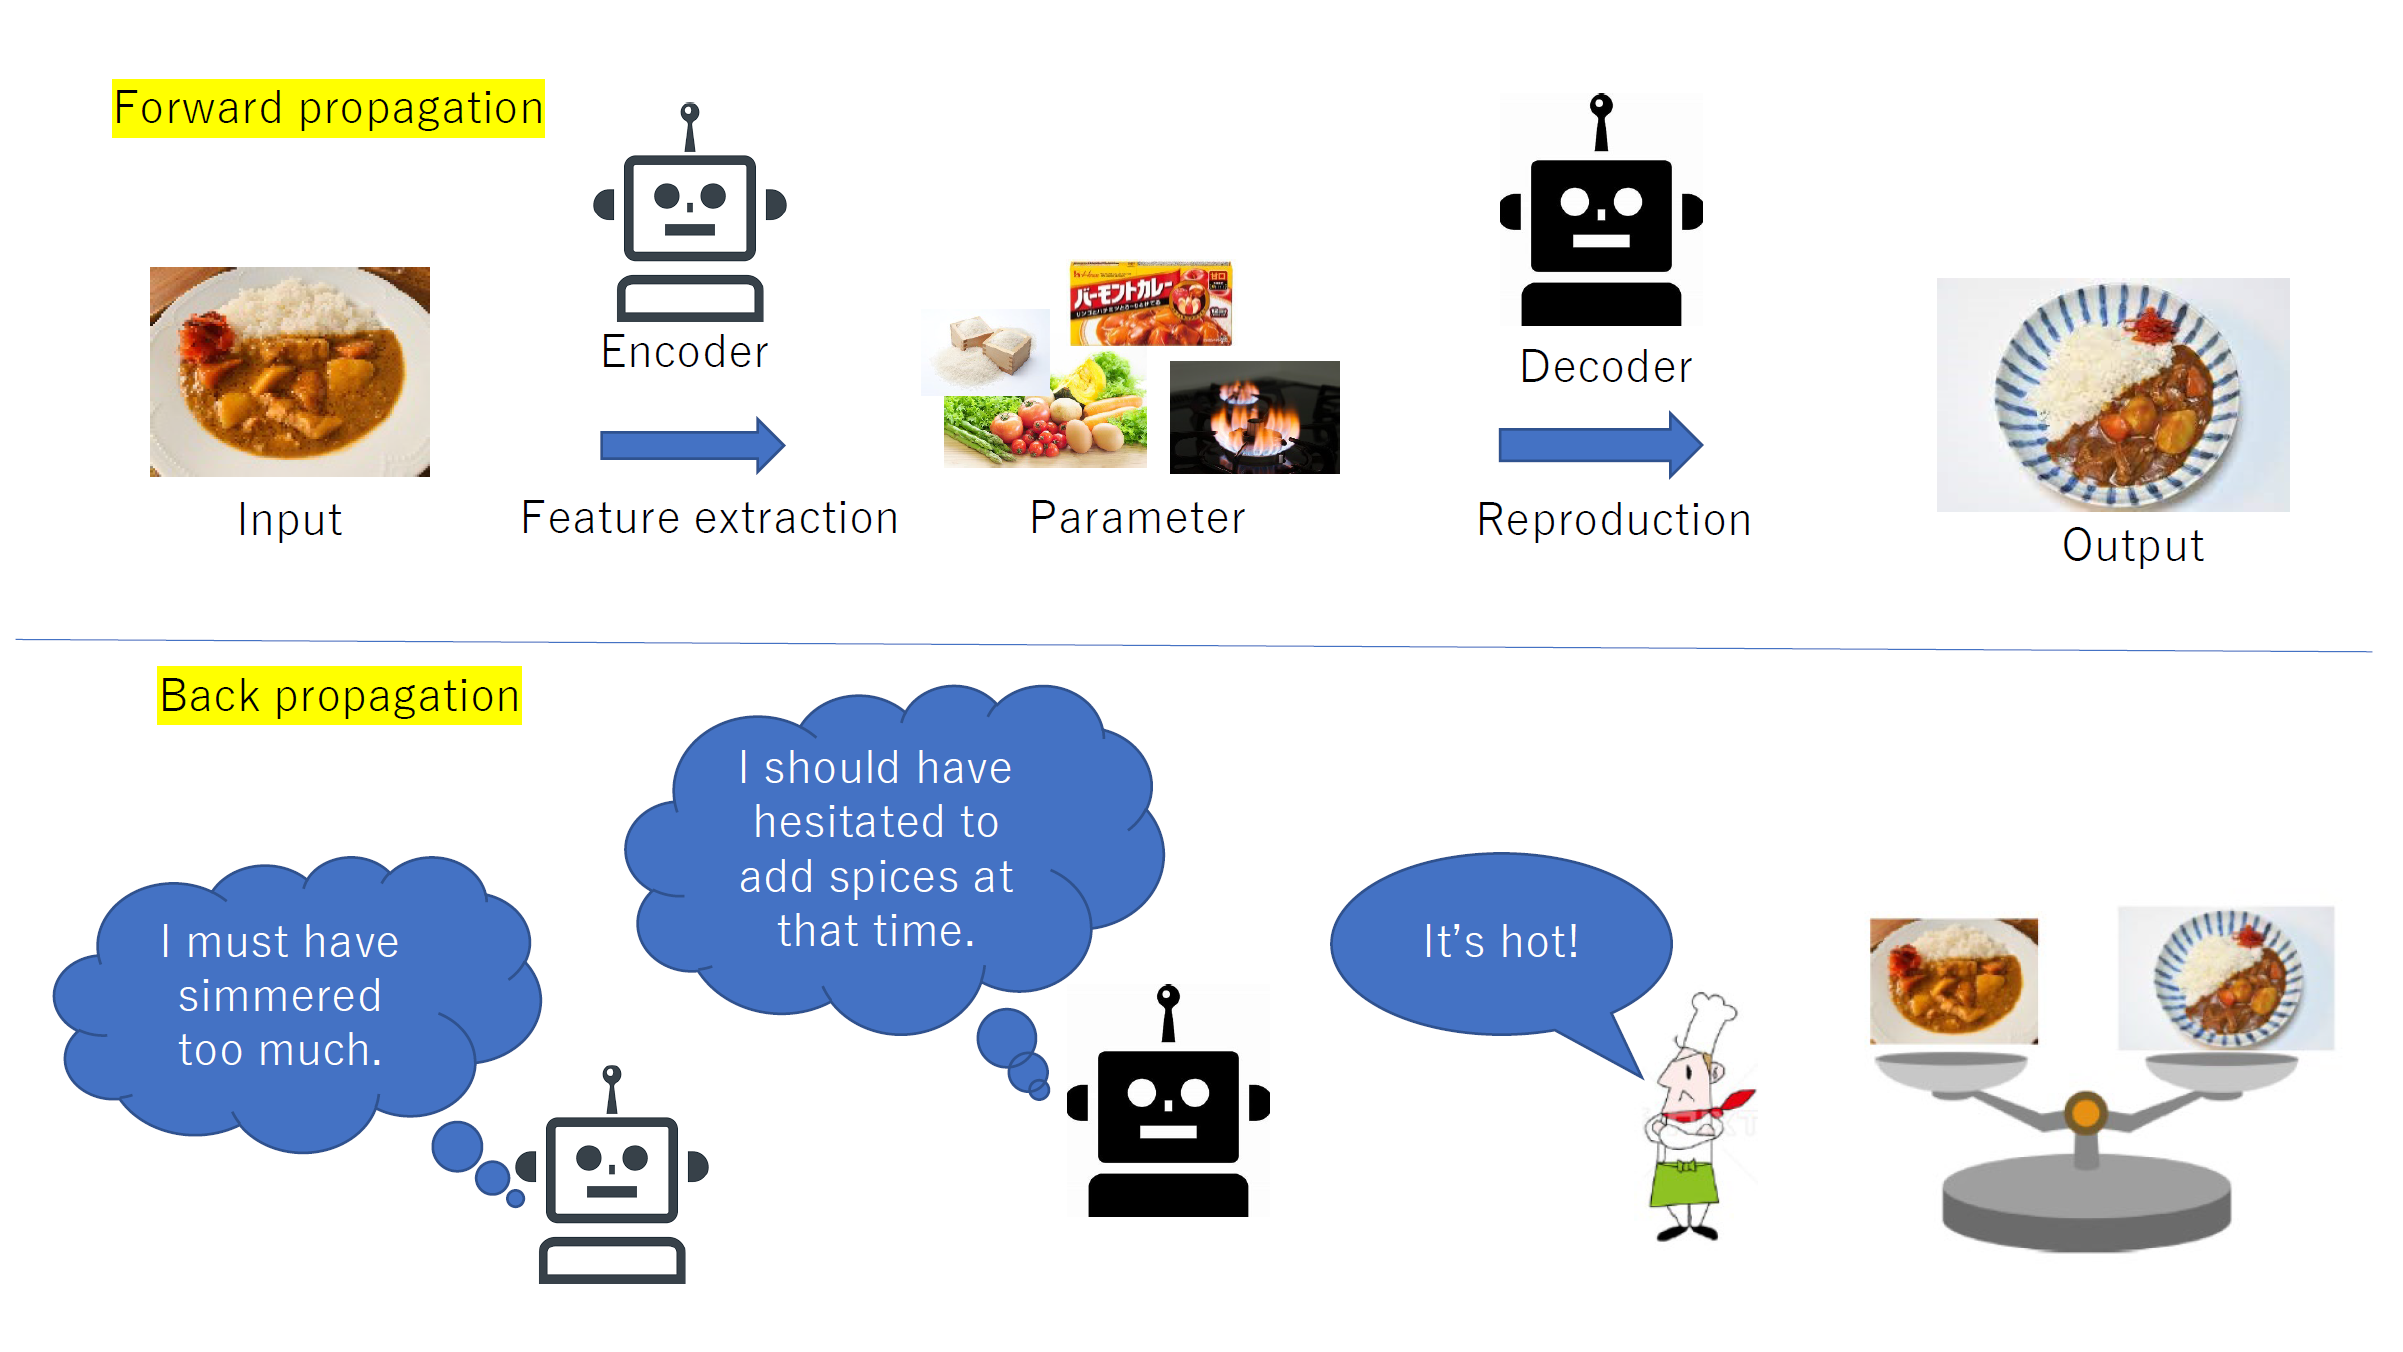

In [ ]:
#18 Back propagation

# Calculating the error
criterion = nn.MSELoss(reduction='mean')
# Update parameters
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
#19 Preparing the GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

AutoEncoder(
  (layers): ModuleList(
    (0): Linear(in_features=320, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): Linear(in_features=128, out_features=8, bias=True)
    (5): Linear(in_features=8, out_features=128, bias=True)
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): Linear(in_features=128, out_features=128, bias=True)
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): Linear(in_features=128, out_features=320, bias=True)
  )
  (bnorms): ModuleList(
    (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm1d(128, eps=1e-05, momentum=0.1

#D. Traing
Start learning and training your autoencorder model.

#D1. Start traning
This time, instead of using all the training data to train the model, we will use 90% (3014) of the training data (3349) to train the model, and the remaining 10% (335) to verify that the training was done properly.

We will use 3014 training data as one set, and repeat this for 50 sets.

In [ ]:
#20 Set the number of times to study
epochs = 50

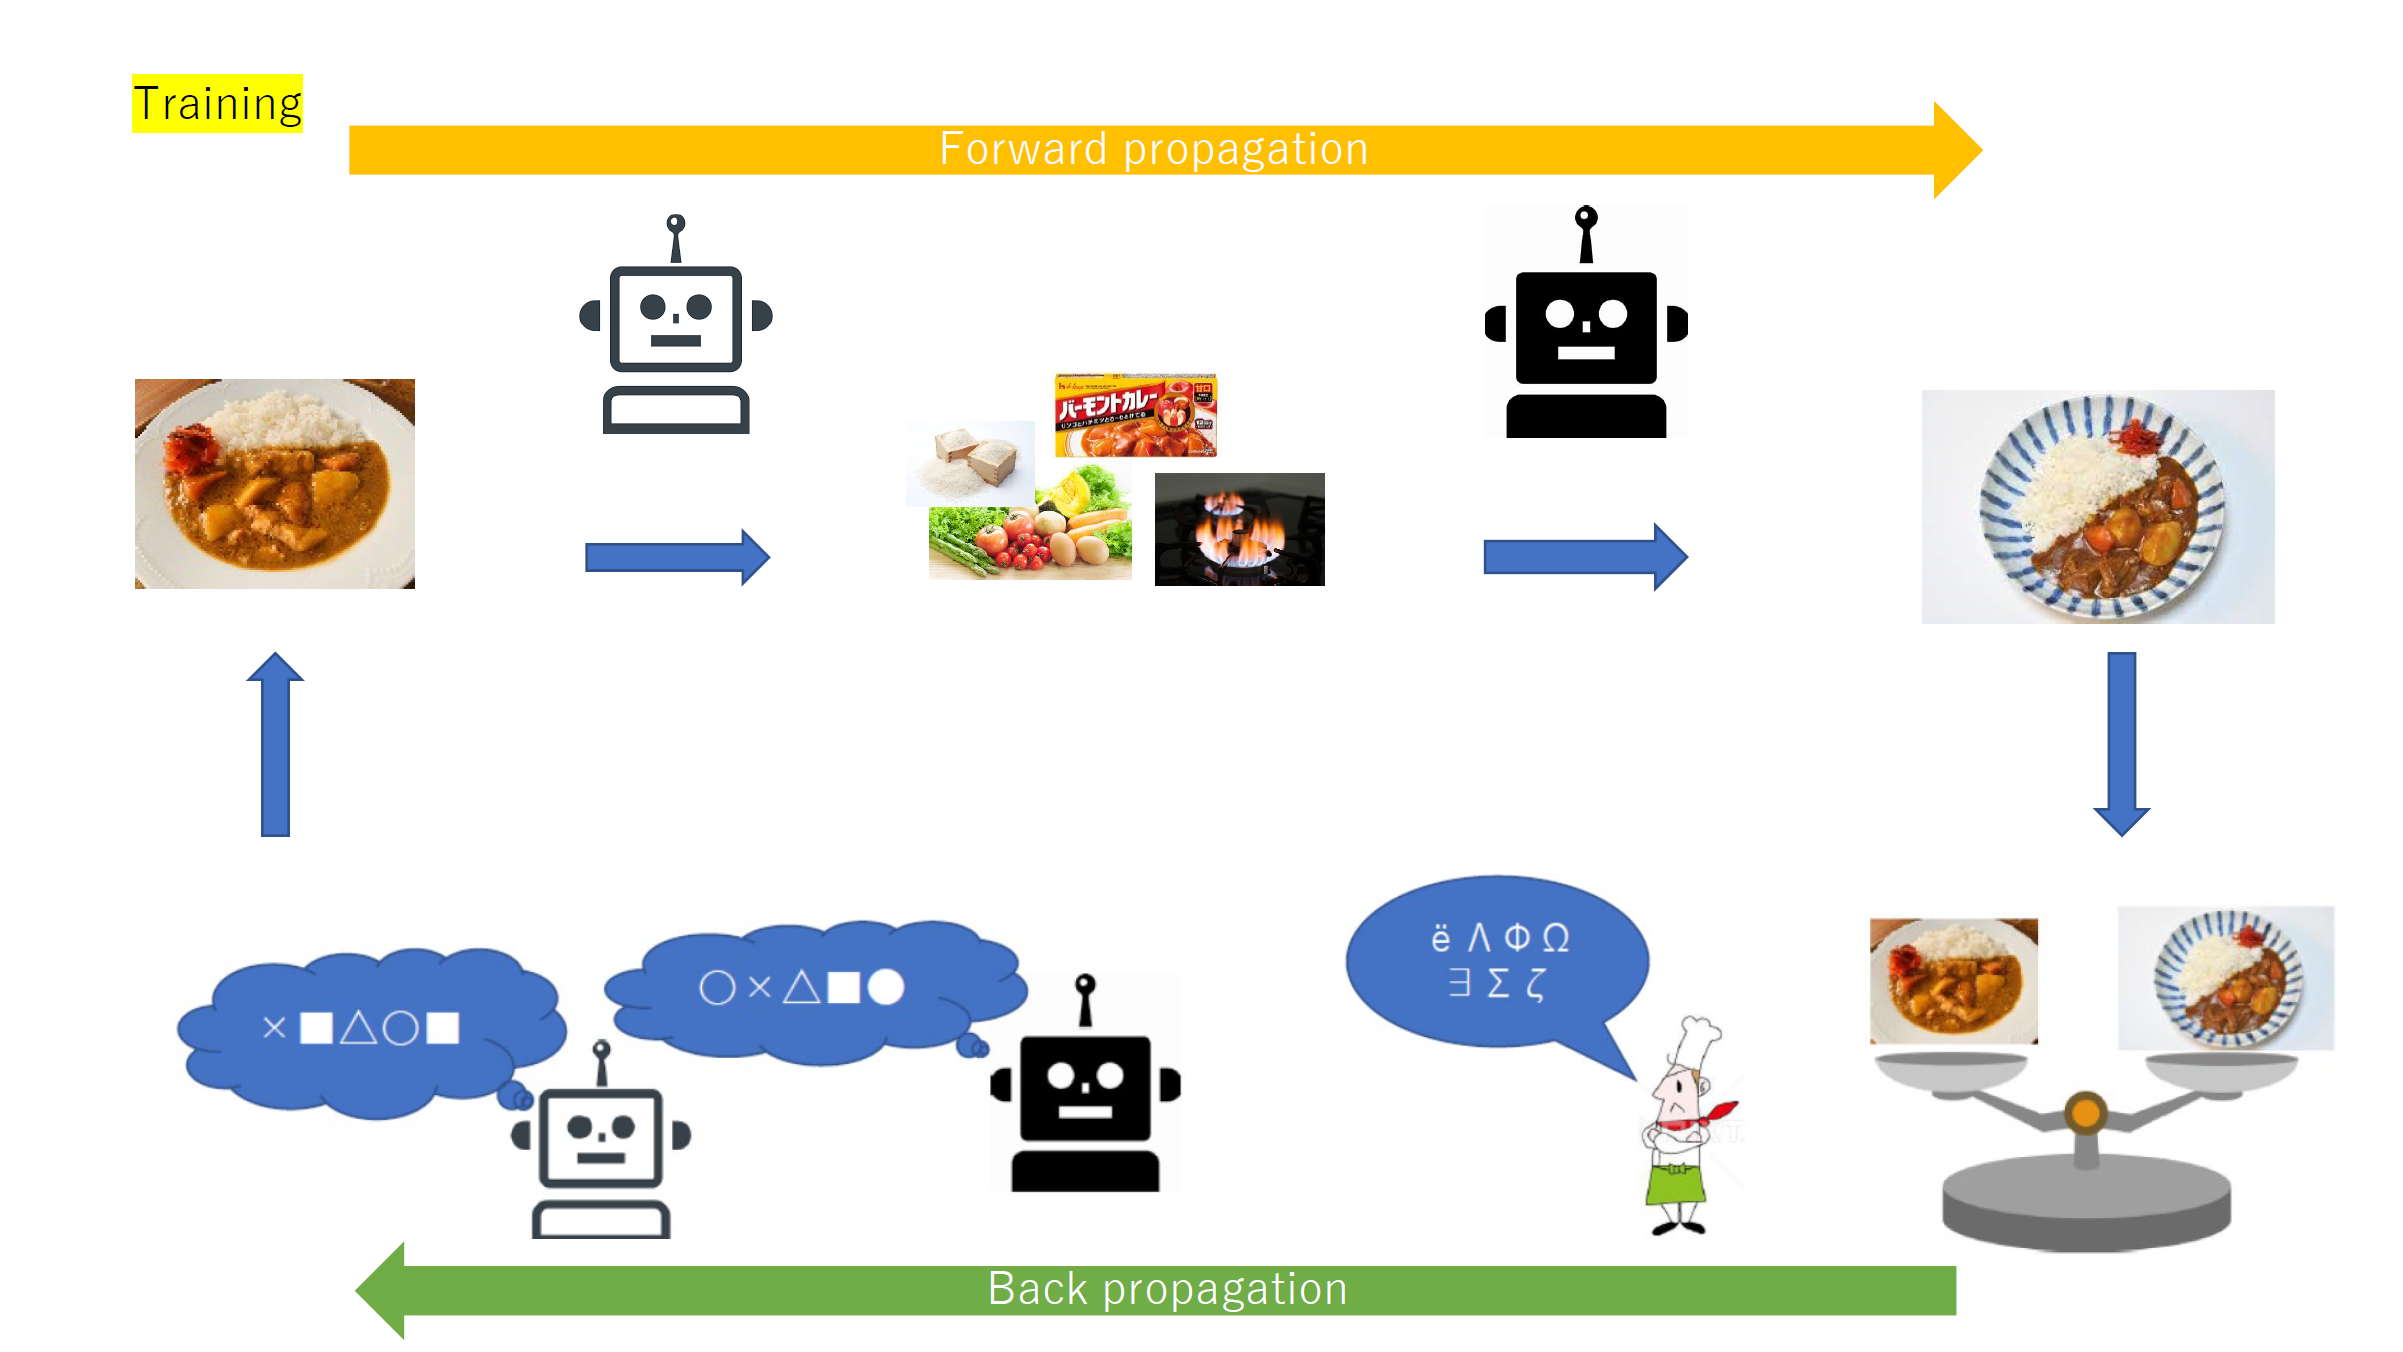

In [ ]:
#21 Carring out learning
logger.info("============== MODEL TRAINING ==============")
train_loss_on_epoch = []
val_loss_on_epoch = []
for epoch in range(1, epochs + 1):
  model.train()
  train_loss = 0
  train_loss_on_batch = []
  for batch_idx, data in enumerate(train_loader):
    data = data.to(device)  # send data to GPU
    data = data.float()  # workaround
    optimizer.zero_grad()
    reconst = model(data)  # reconstruction through auto encoder
    loss = criterion(data, reconst)  # mean squared error
    loss.backward()  # backpropagation
    train_loss += loss.item()
    optimizer.step()  # update paramerters

    train_loss_on_batch.append(loss.to('cpu').detach().numpy().copy())


  model.eval()  # freeze temporarily
  val_loss = 0
  val_loss_on_batch = []
  with torch.no_grad():
    for batch_idx, data in enumerate(val_loader):
      data = data.to(device)  # send data to GPU
      data = data.float()  # workaround
      reconst = model(data)  # reconstruction through auto encoder
      loss = criterion(data, reconst)  # mean squared error
      val_loss += loss.item()

      val_loss_on_batch.append(loss.to('cpu').detach().numpy().copy())

  # average loss over whole mini-batches
  train_epoch_loss = train_loss / len(train_loader)
  val_epoch_loss = val_loss / len(val_loader)

  train_loss_on_epoch.append(np.mean(train_loss_on_batch))
  val_loss_on_epoch.append(np.mean(val_loss_on_batch))


  logger.info('Epoch: {} Average train_loss: {:.6f},' 
              'Average val_loss: {:.6f}'.format(epoch, train_epoch_loss,
                                                val_epoch_loss))
logger.info("============== END TRAINING ==============")

#D.2 Visualize the learning process
By plotting and visualizing the error (loss) during training and validation on  graph, you can get a sense of whether learning has been completed properly.

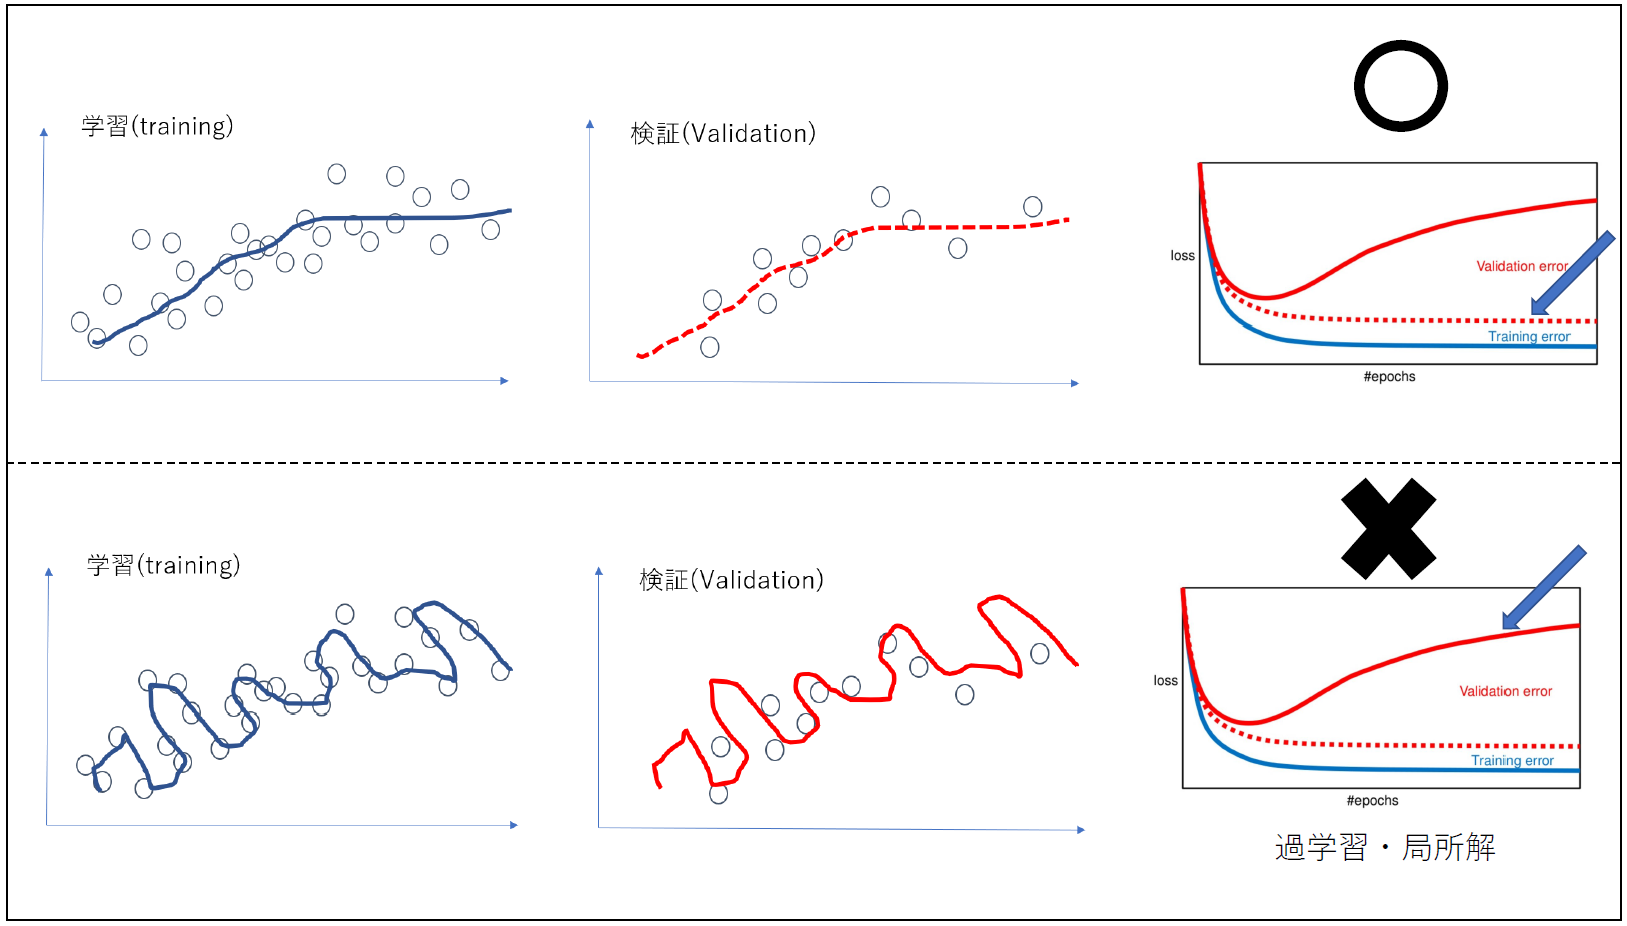

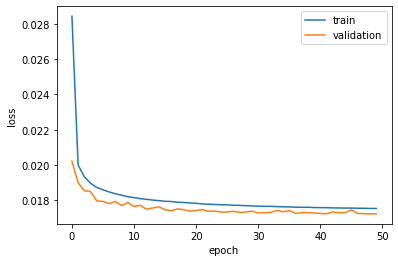

In [ ]:
#22 Plot the error (loss) during training and the error (loss) during validation on a graph
plt.plot(train_loss_on_epoch, label='train')
plt.plot(val_loss_on_epoch, label="validation")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

#E. Confirm the accuracy of the created model

#E.1 Creating a test data set

In this section, we are going to create a test dataset to check the accuracy of the model as same way as that of traing.

In [ ]:
#23 Create a list of sound data for each pump model (ID)
def get_machine_id_list_for_test(target_dir,
                                 dir_name="test",
                                 ext="wav"):
    # create test files
    dir_path = os.path.abspath("{dir}/{dir_name}/*.{ext}".format(
        dir=target_dir, dir_name=dir_name, ext=ext))
    file_paths = sorted(glob.glob(dir_path))
    # extract id
    machine_id_list = sorted(list(set(itertools.chain.from_iterable(
        [re.findall('id_[0-9][0-9]', ext_id) for ext_id in file_paths]))))
    return machine_id_list

In [ ]:
#24 Create a list for testing
def test_file_list_generator(target_dir,
                             id_name,
                             dir_name="test",
                             prefix_normal="normal",
                             prefix_anomaly="anomaly",
                             ext="wav"):
    logger.info("target_dir : {}".format(target_dir+"_"+id_name))

    # development
    
    normal_files = sorted(
        glob.glob("{dir}/{dir_name}/{prefix_normal}_{id_name}*.{ext}"
        .format(dir=target_dir,
                dir_name=dir_name,
                prefix_normal=prefix_normal,
                id_name=id_name,
                ext=ext)))
    normal_labels = np.zeros(len(normal_files))
    anomaly_files = sorted(
        glob.glob("{dir}/{dir_name}/{prefix_anomaly}_{id_name}*.{ext}".
                  format(dir=target_dir,
                         dir_name=dir_name,
                         prefix_anomaly=prefix_anomaly,
                         id_name=id_name,
                         ext=ext)))
    anomaly_labels = np.ones(len(anomaly_files))
    files = np.concatenate((normal_files, anomaly_files), axis=0)
    labels = np.concatenate((normal_labels, anomaly_labels), axis=0)
    logger.info("test_file  num : {num}".format(num=len(files)))
    if len(files) == 0:
      logger.exception("no_wav_file!!")
    logger.info("========================================")

    return files, labels


In [ ]:
#25 Preparing the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#E.2 Use a test dataset to check the accuracy of the trained model
Now, let's check how accurate the autoencorder model is using test deta.

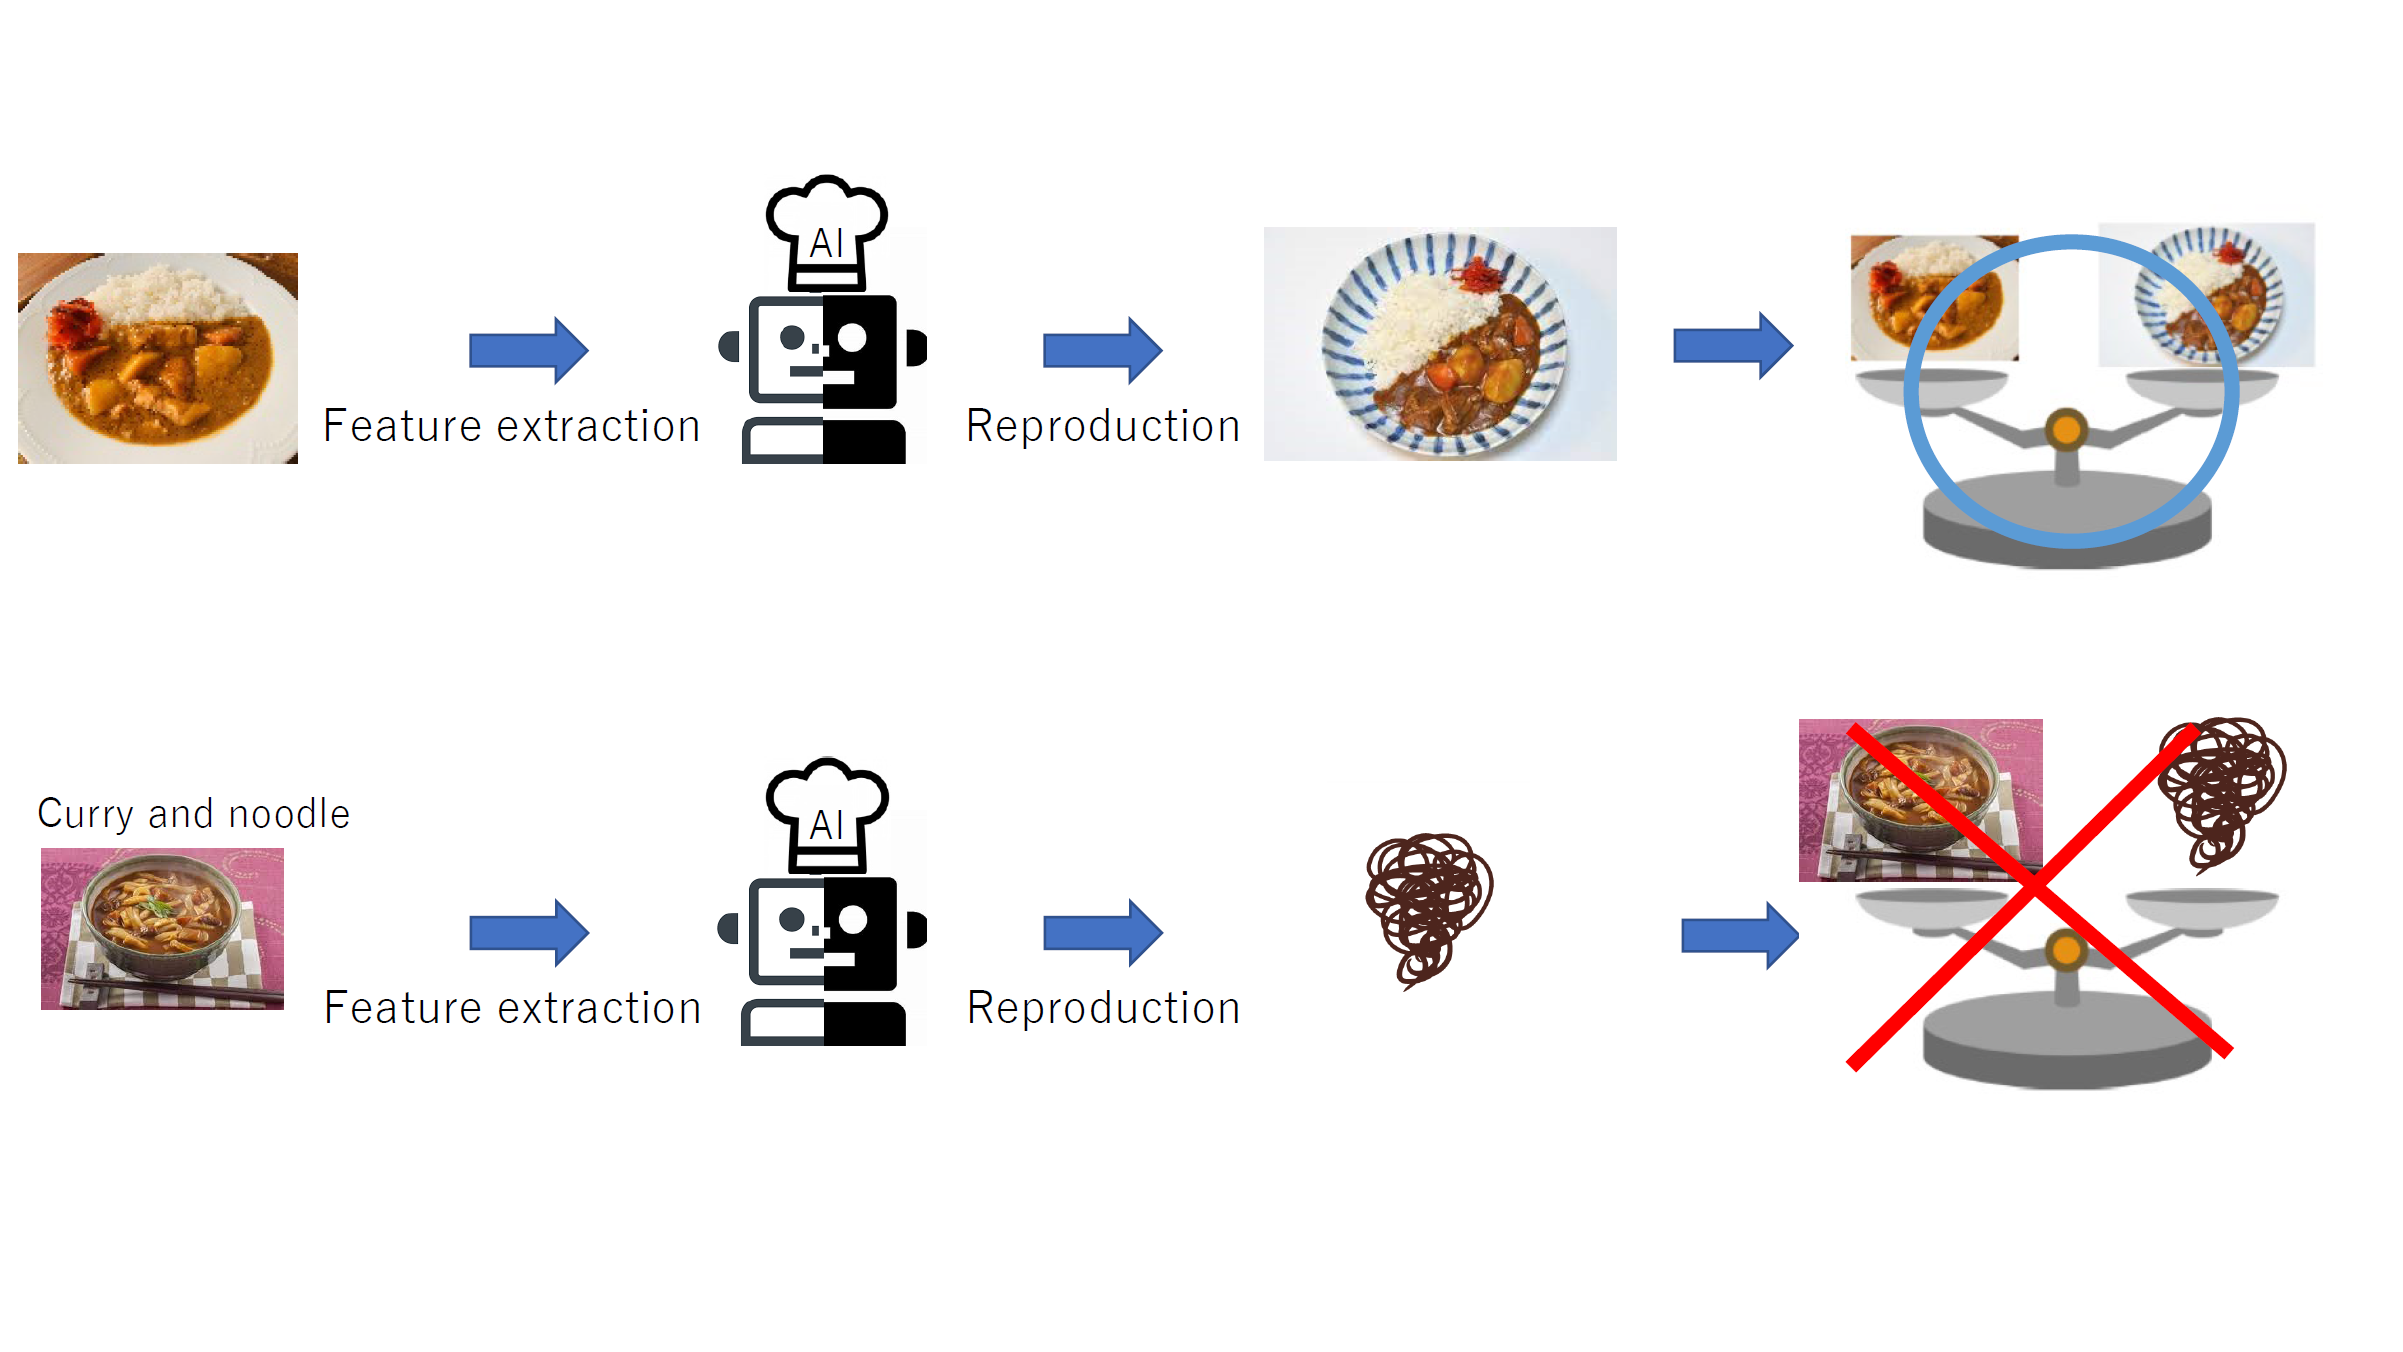

2021-06-07 00:36:41,258 - INFO - target_dir : ./dev_data/pump/_id_00
2021-06-07 00:36:41,263 - INFO - test_file  num : 243
2021-06-07 00:36:41,264 - INFO - ========================================
2021-06-07 00:36:41,266 - INFO - ============== BEGIN TEST FOR A MACHINE ID ==============
2021-06-07 00:36:44,888 - INFO - AUC : 0.6751048951048951
2021-06-07 00:36:44,910 - INFO - ============ END OF TEST FOR A MACHINE ID ============
2021-06-07 00:36:44,911 - INFO - target_dir : ./dev_data/pump/_id_02
2021-06-07 00:36:44,919 - INFO - test_file  num : 211
2021-06-07 00:36:44,920 - INFO - ========================================
2021-06-07 00:36:44,923 - INFO - ============== BEGIN TEST FOR A MACHINE ID ==============
2021-06-07 00:36:48,166 - INFO - AUC : 0.5547747747747749
2021-06-07 00:36:48,173 - INFO - ============ END OF TEST FOR A MACHINE ID ============
2021-06-07 00:36:48,175 - INFO - target_dir : ./dev_data/pump/_id_04
2021-06-07 00:36:48,183 - INFO - test_file  num : 200
2021-06-0

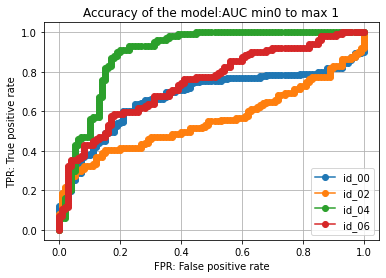

In [ ]:
#26 Output the accuracy of the autoencorder model against 4 different types of pump models. 
import re
import itertools
import sys
from sklearn import metrics


model.eval()

target_dir = esc_dir
performance = []
machine_id_list = get_machine_id_list_for_test(target_dir)

for id_str in machine_id_list:
  # load list of test files
  test_files, y_true = test_file_list_generator(target_dir, id_str)
  anomaly_score_list = []

  logger.info("============== BEGIN TEST FOR A MACHINE ID ==============")

  y_pred = [0. for k in test_files]

  for file_idx, file_path in enumerate(test_files):
    try:
      data = file_to_vector_array(
          file_path,
          n_mels=64,
          frames=5,
          n_fft=1024,
          hop_length=512,
          power=2.0)

      # reconstruction through autoencoder in pytorch
      feed_data = torch.as_tensor(data, device=device, dtype=torch.float32)
      
      with torch.no_grad():
        pred = model(feed_data).to('cpu').detach().numpy().copy()

      errors = np.mean(np.square(data - pred), axis=1)
      y_pred[file_idx] = np.mean(errors)
      anomaly_score_list.append([os.path.basename(file_path), y_pred[file_idx]])
    except FileNotFoundError:
      logger.error("file broken!!: {}".format(file_path))

  # save anomaly score
  #logger.info("anomaly score result ->  {}".format(anomaly_score_csv))
  auc = metrics.roc_auc_score(y_true, y_pred)
  fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred, drop_intermediate=False)
  performance.append([auc])
  logger.info("AUC : {}".format(auc))
  plt.xlabel('FPR: False positive rate')
  plt.ylabel('TPR: True positive rate')
  plt.title('Accuracy of the model:AUC min0 to max 1')
  plt.plot(fpr, tpr, marker='o')
  plt.legend(machine_id_list)
  plt.grid(True)
  logger.info("============ END OF TEST FOR A MACHINE ID ============")
 

# F. Interpratation of the results
In this case, AUC (Area Under the Curve) is used to evaluate the accuracy of the model. The larger the area under the curve, the better the model, and if there is a model that can identify 100 out of 100 shots, the score will be 1.0. The autoencoder model created in this hands-on course has a good discrimination accuracy of close to 0.9 for id_04 pump, but a score close to 0.5 for id_02 pump, making it unsuitable for detecting anormalities in the id_02 pump. (In the case of test data that contains half normal and half abnormal, as in this case, if all of the data is determined to be normal (or anormal), the score will be 0.5 because half of the data can be answered correctly.

# Reference
# DCASE Task2

http://dcase.community/challenge2020/task-unsupervised-detection-of-anomalous-sounds

The original source code in the complete sets are available in the format of tensorflow+keras flamework.